(data-label)=
# Data

In [23]:
import pandas as pd
import os
from matplotlib import pyplot as plt

## 1. Dimensions input data

For this proof of concept we restrict ourself to all publications listed in the Dimensions DB which have been published in 2020 in the main category *Physical Sciences*. The metadata for these publications has been exported to 10 csv files, one for each subfield of physical science according to the  ANZSRC scheme.

### 1.1. Read, clean and reformat data

In [24]:
data_dir = 'Physics_2020_Dimensions'
data_files = ['Dimensions-Publication-2023-02-15_09-57-29.csv', 
            'Dimensions-Publication-2023-02-15_10-19-52.csv', 
            'Dimensions-Publication-2023-02-15_10-18-24.csv',
            'Dimensions-Publication-2023-02-15_10-16-58.csv', 
            'Dimensions-Publication-2023-02-15_10-13-45.csv',
            'Dimensions-Publication-2023-02-15_10-15-28.csv',
            'Dimensions-Publication-2023-02-15_10-07-27.csv',
            'Dimensions-Publication-2023-02-15_10-07-53.csv',
            'Dimensions-Publication-2023-02-15_10-13-05.csv',
            'Dimensions-Publication-2023-02-15_10-12-19.csv']

all_files = [os.path.join(data_dir, file) for file in data_files]
df = pd.concat((pd.read_csv(f, skiprows=1, low_memory=False) for f in all_files))

# keep only columns of intrest
my_columns = ['Rank', 'DOI', 'Title', 
              'Dimensions URL', 'Abstract', 'Fields of Research (ANZSRC 2020)']
df = df[my_columns] 
df.rename(columns={'Fields of Research (ANZSRC 2020)': 'ANZSRC'}, inplace=True)

# drop duplicates. Publication items can be attributed to more than one subfield 
# and the same item  will be listed in more than one input file in such cases
df.drop_duplicates(inplace=True,  keep='last')

Some entries in Dimensions do not have an abstract. As we will be classifying based on the abstracts we need to discard these.

In [25]:
df = df.dropna(subset = ['Abstract'])

Check the length distribution of the abstracts.

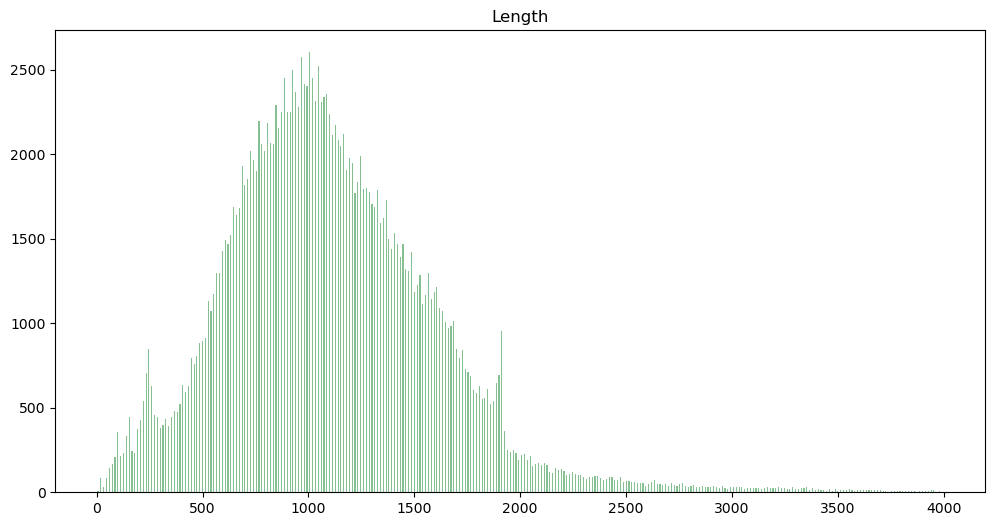

In [26]:
# get lengths of abstracts
len_col = df.Abstract.apply(lambda x: len(x))
df = df.assign(Length=len_col.values)

#plot histogram
df.hist(column='Length', bins=300, grid=False, figsize=(12,6), color='#86bf91', zorder=2, rwidth=0.4, range=[0, 4000])
plt.show()

Shorter abstract will save us money later, those which are too short may not contain enough information for the task at hand. We truncate the distribution and retain abstract between 500 and 1500 characters length only.

In [27]:
df = df[(df['Length'] >= 500) & (df['Length'] <= 1500)]
df = df.reset_index(drop=True)

The ANZSRC is a **multilabel classification** scheme, i.e. **one** and the same **publication item** can be **assigned to** one or more scientific field and within this field to **one or more subfields**. For this study we will only be looking at the 10 subfields of *Physical Sciences*, so our problem is essentially that of a multilabel classification with regard to these 10 subfields.

Next we hence discard all labels except for those 10 subfields of *Physical Sciences*. 

In [32]:
def reduce_labels(labels):
    
    # get list of all subfields of 'Physical Sciences'
    labels_list = [x.lstrip(' ') for x in labels.split(';')]
    labels_list = [x for x in labels_list if x.startswith('51')]
    
    # throw out the label 'Physical Sciences' as this is the oly main category we will be looking at
    labels_list.remove('51 Physical Sciences')
    
    # produce two separate list, one for the numerical labels (e.g. '5109')and one for the text labels
    labels_list = [x.split(' ', 1) for x in labels_list]
    labels_list =  list(map(list, zip(*labels_list)))
    
    # replace comma in 'Atomic, Molecular and Optical Physics' as we will be using the comma as a
    # separator later
    labels_list[1] = list(map(lambda x: x.replace('Atomic, Molecular and Optical Physics',
                                                  'Atomic Molecular and Optical Physics'), 
                                                  labels_list[1]))

    return labels_list

df = df.assign(Labels=df.ANZSRC.apply(lambda x: list(reduce_labels(x))).values)
df[['Labels_num','Labels_str']] = pd.DataFrame(df.Labels.tolist(), index= df.index)

For later convenience we also add a one-hot encoding for the labels.

In [29]:
def boolean_df(item_lists, unique_items):
    bool_dict = {}
    
    for i, item in enumerate(unique_items):
        
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    return pd.DataFrame(bool_dict)

all_labels = list(set([item for sublist in df.Labels_str.values.tolist() for item in sublist])) 

single_label_bool = boolean_df(
  item_lists = df["Labels_str"],
  unique_items = all_labels
)
df = df.join(single_label_bool)

Here is our final data format, which we pickle for later re-use.

In [34]:
df.to_pickle(os.path.join(data_dir, 'dimensions_data_clean.pkl'))
df.head(1)

Rank                    DOI  \
0   500  10.1089/ast.2020.2337   

                                               Title  \
0  The Biological Study of Lifeless Worlds and En...   

                                      Dimensions URL  \
0  https://app.dimensions.ai/details/publication/...   

                                            Abstract  \
0  Astrobiology is focused on the study of life i...   

                                             ANZSRC  Length  \
0  51 Physical Sciences; 5101 Astronomical Sciences    1211   

                              Labels Labels_num               Labels_str  \
0  [[5101], [Astronomical Sciences]]     [5101]  [Astronomical Sciences]   

   Space Sciences  Quantum Physics  Atomic Molecular and Optical Physics  \
0           False            False                                 False   

   Medical and Biological Physics  Synchrotrons and Accelerators  \
0                           False                          False   

   Classical Physics  Condensed Matter Physics  \
0              False                     False   

   Particle and High Energy Physics  Astronomical Sciences  \
0                             False                   True   

   Nuclear and Plasma Physics  
0                       False